# Állapotbecslés, adat asszimiláció

Ebben a pontban megnézzük, hogyan nyerhetünk viszonylag pontos információt egy véletlen zaj által zavart dinamikai állapotáról, ha esetleg csak alacsonyabb dimenziós és szintén zajos mérési adatok állnak rendelkezésre.

Hol találkozhatunk ilyen feladatokkal?

Például:

* Robotok és önvezető járművek esetén a különféle szenzorok adataiból a szerkezet valódi helyzetét és (robot esetén) konfigurációját kell meghatározni. Ezt hívják **szenzorfúziónak**. Ide sorolhatjuk a katonai alkalmazások területéről a különféle irányított rakéták célravezetését is. Lényegében ez az alkalmazás tette népszerűvé a Kálman-szűrőt.

* Oceanográfiában és meteorológiában igen gyakran előforduló feladat, hogy adott egy igen nagy dimenziós dinamikai rendszer (amit például áramlás, hő és egyéb transzport egyenletek diszkretizációjával nyerünk), és rendelkezésre állnak (a cellaszámhoz képest) jóval ritkábban mérési eredmények (szél, hőmérséklet, víz áramlási sebessége, stb.). A feladat pedig az, hogy a rendelkezésre álló adatokból minél pontosabb képet kapjunk az egész rendszer (légkör, óceán) állapotáról és előre tudjuk jelezni annak jövőjét. Ezt nevezik **adat asszimilációnak**.

Az állapotbecslő algoritmusoknak két nagy családja létezik: szekvenciális Monte-Carlo eljárások, más néven részecskeszűrők (particle filter) és a különféle Kálmán szűrők.

A részecskeszűrőkre gondolhatunk úgy is mint nemparaméteres becslő algoritmusokra. Előnyük, hogy a segítségükkel nem Gauss zajjal terhelt nemlineáris dinamikák is kezelhetők. Hátrányuk, hogy a számítási igény a dimenzióval rohamosan nő (curse of dimensionality).

A Kálmán szűrők ezzel ellentétben hatékonyan működnek magas dimenziós rendszerekre is, de a hátrányuk az, hogy csak olyan rendszerekre működnek, ahol a rendzer jó közelítéssel lineáris, az additív zaj pedig Gauss eloszlású.

## Részecskeszűrők (nemlineáris rendszerek)

Tegyük fel, hogy adott egy $f_k: \mathbb{R}^n\times\mathbb{R}\to\mathbb{R}^n$, $k\in\mathbb{N}$ véletlen dinamikát definiáló leképezés sorozat és $g: \mathbb{R}^n\times\mathbb{R}\to \mathbb{R}^m$ zajos mérést leíró függvény. Továbbá legyen $(\xi_k)_{k\in\mathbb{N}}$ és $(\eta_k)_{k\in\mathbb{N}}$ $\mathbb{R}$-értékű valószínűségi változók egymástól független sorozata, $x_0\in\mathbb{R}^n$ pedig kezdőérték, mely független a két meghajtó zaj sorozattól (akár determinisztikus is lehet).

Tekintsük az

\begin{align}
x_{k+1} &= f_k (x_k,\xi_{k+1}),\,\,k\ge 0\\
y_{k} &= g(x_k,\eta_k),\,\,k\ge 0
\end{align}

véletlen rekurziót. Megjegyezzük, hogy tetszőleges véletlen dinamikai rendszer és a rendszert leíró állapotvektoron végrehajtott mérés eredménye felírható ilyen alakban, feltéve, hogy a mérés eredményét a korábbi állapotok nem befolyásolják.

Az egyszerűség kedvéért feltesszük, hogy a problémában szereplő összes valószínűségi változó Lebesgue mértékre nézve abszolút folytonos eloszlású (van sűrűségfüggvénye). Jelentse $p(x_{k}|y_{0:k})$ az $x_k$ állapotvektor sűrűségfüggvényét, feltéve, hogy a $k$-adik időpillanatig bezárólag $y_{0:k}$ értékeket mértünk. 

Az állapotbecslési feladat ezen sűrűségfüggvény meghatározása.

Tegyük fel, hogy a műszerünket annyira ismerjük, hogy meg tudjuk mondani a mérési eredmény sűrűségfüggvényét, amennyiben az állapot ismert. Legyen ez $p(y|x)$ és tekintsük az alábbi Bayes becslést
\begin{align*}
\mathbf{p(x_{k}|y_{1:k})} &= \frac{p(y_{k}|x_k,y_{1:k-1})p(x_k|y_{1:k-1})}{p(y_k|y_{1:k-1})} \\
&= \frac{p(y_{k}|x_k,y_{1:k-1})p(x_k|x_{k-1},y_{1:k-1})p(x_{k-1}|y_{1:k-1})}{p(y_k|y_{1:k-1})} \\
&= \frac{p(y_{k}|x_k)p(x_k|x_{k-1})}{p(y_k|y_{1:k-1})}\times \mathbf{p(x_{k-1}|y_{1:k-1})},
\end{align*}
ahol használtuk, hogy
* az $x_k$ állapot az $x_{k-1}$ korábbi állapotot feltételezve *független* a múltbeli mérésektől, azaz $p(x_k|x_{k-1},y_{1:k-1})=p(x_k|x_{k-1})$, valamint
* az $y_k$ mérési eredmény az $x_k$ állapot ismeretében szintén *független* a múltbeli értékektől, azaz $p(y_{k}|x_k,y_{1:k-1})=p(y_{k}|x_k)$.

Összefoglalva: a becslés az újabb mérési eredmény birtokában a
$$
\mathbf{p(x_{k}|y_{1:k}) 
\propto
p(y_{k}|x_k)p(x_k|x_{k-1})\times p(x_{k-1}|y_{1:k-1})}
$$
szabály szerint aktualizálódik.

Ezzel csak az a probléma technikai szempontból, hogy $p(x_k|x_{k-1})$ átmenet sűrűség előzetesen nem ismert, illetve számításigény szempontjából nagyon nem hatékony sűrűségfüggvényekkel számolni. Ezen a problémán segít a részecskeszűrő (particle filter, vagy szekvenciális Monte-Carlo).

Tegyük fel, hogy adott $N$ (véges sok) súly, $w_1^{(k)},w_2^{(k)},\ldots,w_N^{(k)}$ minden egyes lépésben, illetve adottak $x_1^{(k)},x_2^{(k)},\ldots,x_N^{(k)}$ állapotvektorok (részecskék), és feltételezzük, hogy $x_k$ eloszlása ezen pontokra koncentrálódik:
$$
p(x_{k}|y_{1:k}) = \sum_{j=1}^N w_j^{(k)}\delta_{x_j^{(k)}},
$$
ahol $\delta_{x_j^{(k)}}$ az $x_j^{(k)}$ pontra koncentrált Dirac-delta disztribúció.

Az $y_k$ mérési eredmény birtokában a léptetést végrehajtva $j=1,\ldots,N$-re kapjuk, hogy
\begin{align*}
x_j^{(k)} &= f_{k-1}(x_j^{(k-1)},\xi_k)\\
w_j^{(k)} &\propto p(y_{k}|x_j^{(k)}) w_j^{(k-1)},
\end{align*}

a $k$-adik állapot becslése pedig $\hat{x}_k=\sum_{j=1}^N w_j^{(k)}x_j^{(k)}$. Az ún. újramintavételezés szükségességét és mikéntjét illetően lásd a kódbeli kommenteket.

In [28]:
import numpy as np

f = lambda x, k: 0.5*x + 25.0*x/(1+x**2.0)+8.0*np.cos(1.2*k) + np.sqrt(10.0)*np.random.normal()  # a [2] cikk VI. fejezetében vázolt nemlineáris dinamika

def nonlinear_system():
    """
    Nemlineáris dinamikai rendszer.
    
    x_{k+1} = f(x_k, k) + v_{k+1},
    
    ahol v_{k+1} sqrt(10.0) szórásnégyzetű, 
    0.0 várhatóértékű normális eloszlású valószínűségi változó.
    """
    
    x = 0.0
    k = 0
    
    while True:
        yield x
        x = f(x, k)
        k = k+1
    
obs = lambda x: 0.05*x**2.0  # pontos mérés
obs_noise = lambda x: obs(x) + np.random.normal() # zajos mérés

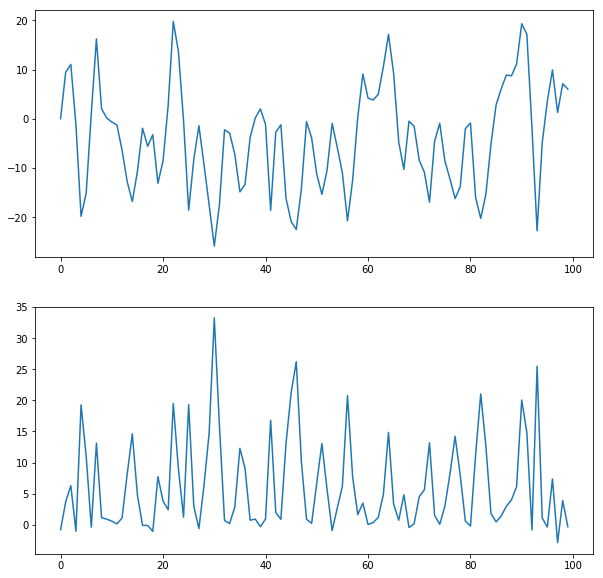

In [29]:
import matplotlib.pyplot as plt 

nls = nonlinear_system()
x = np.array([next(nls) for k in range(100)])
y = np.array([obs_noise(xk) for xk in x])  # zajos mérés

_, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(x)
ax[1].plot(y)

In [37]:
import numpy as np

class ParticleFilter:
    """
    Bootstrap Particle filter algoritmus multinomiális újramintavételezéssel.
    
    Az alábbi cikkhez tartozó MATLAB implementációt írtam át Python-ra, egyszerűsítettem le, és értettem meg.
    
    Arulampalam et. al. (2002).  A tutorial on particle filters for online nonlinear/non-gaussian bayesian tracking. 
    IEEE Transactions on Signal Processing. 50 (2). p 174--188
    """
    
    # jelölések: nx az állapottér dimenziója, Ns a részecskék száma
    
    f = None             # f(x,k) alakú, véletlen dinamikát megadó függvény
    p_yk_given_xk = None # p(xk|yk) feltételes sűrűségfüggvény
    
    weights = None   # súlyok (Ns,)
    particles = None # részecskék (Ns, nx)
    
    def __init__(self, f, p_yk_given_xk, Ns, gen_x0):
        """
        Bootstrap particle filter
        
        Ns: részecskék száma
        gen_x0: függvény, mellyel a p(x_0) sűrűségfüggvényű eloszlásból generálható véletlen (prior)
        /(nx,)/ méretet generál
        """
        
        self.f = f  # fun(x,k) szignatúra
        self.p_yk_given_xk = p_yk_given_xk  # fun(yk, xk) szigantúra, a mérés időben homogén
        
        self.weights = (1/Ns)*np.ones((Ns,))
        self.particles = np.array([gen_x0() for k in range(Ns)])
        
    
    def particle_filter(self, k: int, yk: np.ndarray)->np.ndarray:
        """
        k:  időpont (a dinamika nem autonóm)
        yk: mérési eredmény
        """
        
        Ns = self.particles.shape[0]  # részecskék száma
        
        # forward propagation, ez a részecskék várható új állapota
        xk = np.array([self.f(self.particles[i], k) for i in range(Ns)])
        
        # ez azt adja meg kb., hogy mekkora "valószínűséggel" mérünk yk-t, ha xk volt az igazi állapot,
        # azaz a mérési eredmény birtokában súlyozzok a jóslatainkat.
        wk = self.weights*np.array([self.p_yk_given_xk(yk, xk[i]) for i in range(Ns)])
        wk = wk/np.sum(wk)  # Súlyok normalizálása
        
        """
        Előfordulhat, hogy egy idő után a részecskék egy része "elkószál", így csak nagyon kis súllyal szerepel az állapotbecslésben
        Ezen segít a resampling, ami egy ún. importance sampling technika: a részecskékből a likelihood függvény
        szerinti valószínűséggel visszatevéses mintavételt hajtunk végre. Ha ezt minden lépésben megtesszük, azt hívják
        úgy, hogy Bootstrap Particle Filter
        """
        
        idx = np.random.choice(Ns, size=Ns, replace=True, p=wk)
        
        # Az új részecskékhez tartozó állapotvektorok
        xk = xk[idx]
        
        # A kiszelektált részecskékhez egyforma súlyokat rendelünk
        wk = (1/Ns)*np.ones_like(wk)
        
        self.weights = wk
        self.particles = xk
        
        return wk@xk

In [54]:
from scipy.stats import norm  # innen jön a gauss sűrűségfüggvény

gen_x0 = lambda: np.sqrt(10.0)*np.random.normal()
p_yk_given_xk = lambda yk, xk: norm.pdf(yk - obs(xk))

#Ns = 10
Ns = 100
#Ns = 1000  # generált részecskék száma

# Feladat: próbáljuk ki, hogy a részecske-szám változtatásával hogyan változik a gépidő és az állapotbecslés pontossága

PF = ParticleFilter(f, p_yk_given_xk, Ns, gen_x0)

nls = nonlinear_system()

T = 100  # Eddig futtatjuk

x = []  # Igazi állapot
xhat = []  # Zajos mérésből becsült állapot

for k in range(T):
    xk = next(nls)     # tényleges következő állapot
    yk = obs_noise(xk) # zajos mérési eredmény
    
    xhatk = PF.particle_filter(k, yk)  # tényleges állapot becslése a mérési eredményből
    
    x.append(xk)
    xhat.append(xhatk)
    
x = np.array(x)
xhat = np.array(xhat)

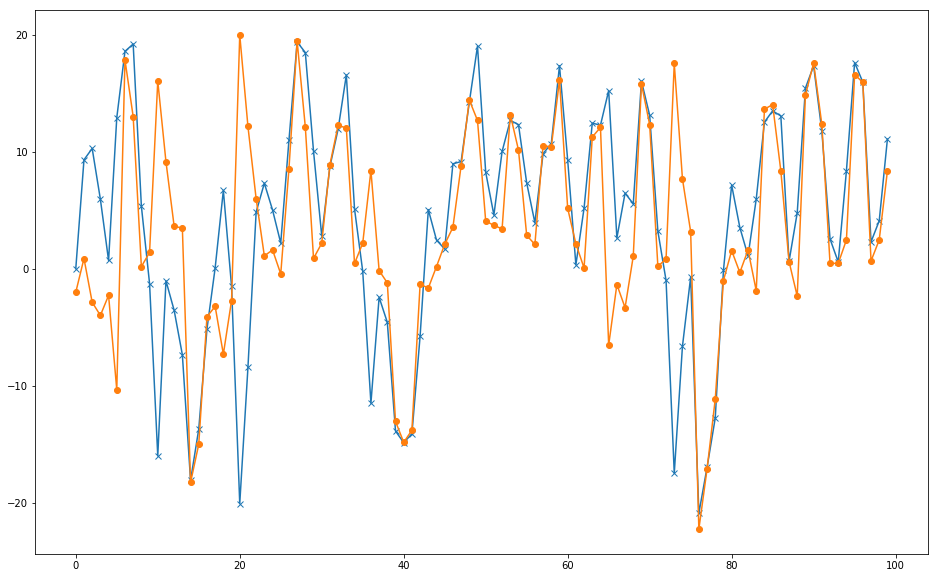

In [55]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(16, 10))

ax.plot(x,'x-')      # Tényleges érték
ax.plot(xhat, 'o-')  # Becslés

## A Kálmán szűrő (lineáris rendszerek)

A normális (Gauss) eloszlás két adattal jellemezhető: várhatóérték vektorával és kovariancia mátrixábal. Ennek az eloszlás típusnak egyik érdekes és jellemző tulajdonsága, hogy ha $x\sim \mathcal{N} (\mu, \Sigma)$, akkor $Ax+b\sim \mathcal{N} (A\mu + b, A\Sigma A^\top)$ eloszlású. Ez teszi lehetővé, hogy additív zajjal terhelt lineáris dinamikák esetén a szűrési problémában felmerülő sűrűségfüggvények helyett a szóban forgó valószínűségi változók várhatóérték vektoraival és kovariancia mátrixaival is számolhatunk. Ez a *Kálmán-szűrő működésének az alapja*, az algoritmus pedig a következő:

Tegyük fel, hogy a dinamika $x_{k+1}=A_{k+1}x_k+b_{k+1}+\xi_{k+1}$ alakú, ahol $\xi_k\sim\mathcal{N}(0,Q_k)$, mérés pedig $y_k = H x_k + \eta_k$, itt pedig $\eta_k\sim\mathcal{N}(0,R)$. Tehát a dinamika lépésenként változhat, de --az egyszerűség kedvéért-- mindig ugyanúgy mérünk.

A Kálmán-szűrő algoritmus egy predikciós és egy frissítés lépésből áll. Jelölje $\hat{x}_{k|j}$ az $x_k$ állapotvektor várhatóértékének becslését, amennyiben $y_1,\ldots,y_j$ mérési eredmények ismertek (az algoritmusban csak $j=k-1$ és $j=k$ szerepel). Hasonlóan, jelentse $C_{k|j}$ az $x_k$ állapotvektor kovariancia mátrixának a becslését.

Predikciós lépés:

1. $\hat{x}_{k|k-1} = A_k\hat{x}_{k-1|k-1}+b_k$
2. $C_{k|k-1} = A_kC_{k|k-1}A_k^\top + Q_k$

Frissítés:
1. $z_k = y_k - H \hat{x}_{k|k-1}$ (ezt nevezik innovációnak)
2. $S_k = H C_{k|k-1}H^\top + R$ (ez az innovációs kovariancia)
3. $K_k = C_{k|k-1}H^\top S_k^{-1}$ (ez az optimális Kalman-nyereség)
4. $\hat{x}_{k|k}=\hat{x}_{k|k-1}+K_k z_k$ (frissített állapot)
5. $C_{k|k}=(I-K_k H)C_{k|k-1}$ (frissített kovariancia)

### Feladat: kétdimenziós lineáris rendszer állapotbecslése

Az alábbi cella egy kétdimenziós zajjal terhelt dinamikai rendszer, illetve ezen rendszer méréséhez tartozó programkódot tartalmazza. Implementáljuk a leírásban szereplő Kálmán-szűrő algoritmust és a részecskeszűrős feladat mintájára rajzoltassuk ki a rendszer időfejlődését, illetve a mérési eredményekből a szűrő algoritmus segítségével számított állapotbecsléseket.

In [71]:
A = np.array([[-2, -1],
              [2, -2]])

A = np.eye(2)+0.01*A

b = np.array([1, 2])

B = 0.05*np.array([[2, 1],
              [3, 4]])

Q = B@B.T  # ez a kovariancia mátrix.

H = np.array([-2, 3])

R = 0.1

def linear_2d():
    x = np.array([0, 0])
    
    while True:
        yield x
        x = A@x + b + B@np.random.normal(size=(2,))

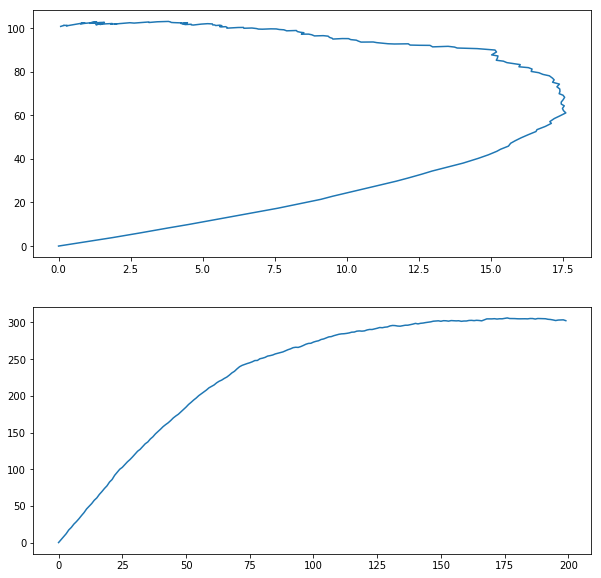

In [75]:
lin_sys = linear_2d()

x = np.array([next(lin_sys) for k in range(200)])
y = np.array([H@xk+R*np.random.normal() for xk in x])  # zajos mérés

_, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(x[:,0],x[:,1])
ax[1].plot(y)

### Feladat: radarvezérelt légvédelmi gépágyú programozása

A rakéta, tüzérségi és aknavető elhárító rendszerek (C-RAM, Counter Rocket, Artillery, and Mortar) a taktikai légvédelem részét képezik, feladatuk a ballisztikus pályán haladó célok leküzdése. Ilyen rendszer például az amerikai Phalanx vagy az orosz AK-630-as. Közös jellemzőjük, hogy egy nagy tűzgyorsaságú radar és egyéb jel (optikai, infra) által vezérelt légvédelmi gépágyúval semmisítik meg a célt.

Ebben a feladatban egy Tulipán-2SZ4 (ТЮЛЬПАН-2С4) önjáró aknavetőből kilőtt 240mm-es gránát AK-630-as taktikai légvédelmi rendszerrel történő megsemmisítését szimuláljuk a következők ismeretében:

* A gépágyúval egybeépített tűzvezető radar akkor látja a célt, ha az legalább 30,5 m magasan van.
* A lövedék ballisztikus pályán mozog, a radar pedig csak a lövedék távolságát adja meg, azt is némi hibával terhelve, és 0,01 s-ként kapunk új mérési eredményt, mellyel a célzás pontosítható.
* Az AK-630-as rendszer hatékony lőtávolsága 4000 m, ezen belül nyitunk csak tüzet, a torkolati sebesség 885 m/s.
* Ha a radar a célt X méter távolságra mérte, akkor a gépágyúlövedék X/885 s alatt ér oda, így oda kell lőni, ahová a cél ennyi idő múlva várható. (Erősen leegyszerűsítve.)
* A radarernyő alá, azaz 30,5 m-nél alacsonyabban haladó célra nem lövünk.

A részleteket az alábbi kód tartalmazza, de erre csak közvetve lesz szükségünk. Persze rengeteg egyszerűsítő feltevéssel éltünk, főleg a jelek terjedési sebességét illetően. A lövés pontosságával szintén nem számoltunk.

#### Feladatok

1. Implementáljuk a Kálmán-szűrő algoritmust úgy, hogy minden lépésben a rendszer linearizáltját használjuk predikcióra.

2. Rajzoltassuk ki az aknagránát röppályáját és a becsült röppályát abban a tartományban, amikor a lövedék már lőtávolságon belülre ért.

3. Eltaláltuk-e a célt, azaz van-e olyan időpont, amikor a becsült és a tényleges röppálya közelebb van egymáshoz, mint 0,12 m?

#### Szorgalmi feladat (2-t ér!)

Helyezzünk el még egy radart a pályán, az aknavető és a légvédelmi egység között félúton. Ez az új radar szintén a gránát aktuális távolságát méri. 

Ismételjük meg a fenti szimulációt az új bejövő adat birtokában. 

Igaz-e, hogy így már korábban le sikerül lőni a célt?

In [22]:
def projectile():
    """
    A lövedék x és z koordinátáit adja vissza.
    
    kaliber: 240 mm
    Дальность стрельбы, км -- lőtávolság: 0,8-9,81 km (a 19,98km-es max érték csak rakéta póthajtással érhető el)
    2с4 тюльпан начальная скорость снаряда -- lövedék kezdősebessége: 158-382 m/s 
    Угол возвышения -- magassági szög: 45°-80°
    Масса снаряда, кг -- lövedék tömege: 130,7 kg
    """
    
    # sampling_time
    dt = 0.01  # ennyi másodpercenként számoljuk újra a koordinátákat
    
    # gravitációs gyorsulás és légellenállás adatok
    g = 9.81  # m/s^2
    
    k = 0.15  # légellenállás tényező
    A = np.pi*0.12**2.0  # az aknagránát homlokfelülete m^2
    rho = 1.2255  # kg/m³ a levegő sűrűsége
    
    c = k*A*rho/130.7  # c*v^2 egyből a lassulást adja majd
    
    x0, y0 = 1.0e4, 30.5 # 20km-ről lőttek, a radarernyőbe érve vált láthatóvá a lövedék 
    
    alpha = np.deg2rad(180-45)  # irányszög (45°, felénk)
    v0 = 382  # kezdősebesség (m/s)
    
    # Kezdeti hely, sebesség és gyorsulás x és y irányban
    rx = np.array([x0, v0*np.cos(alpha), 0.0])
    ry = np.array([y0, v0*np.sin(alpha), 0.0])
    
    P = np.array([[1, dt, 0.5*dt**2.0],  # időléptetés lineáris részét leíró mátrix
                  [0, 1, dt],
                  [0, 0, 1]])

    # Zaj tényező (szél, légkör okozta bizonytalanság)
    sigma = 10.0
    
    # Az egyszerűség kedvéért feltételezzük, hogy a radar 100 láb, azaz kb. 30,5 m
    # magasság alatt már nem látja a célt. Azaz ha a cél ez alá süllyed,
    # akkor nem sikerült eltalálni.
    while ry[0] >= 30.5:
        yield rx[0], ry[0]
        
        v = np.sqrt(rx[1]**2.0+ry[1]**2.0) # sebesség nagysága
        drag = c*v**2.0
        ax = -drag*rx[1]/v   + sigma*np.random.normal()
        ay = -drag*ry[1]/v-g + sigma*np.random.normal()
        
        rx, ry = P@rx, P@ry
        rx[2], ry[2] = ax, ay

        
def radar_signal(x, y):
    """
    Zajos távolság értéket ad vissza
    """
    
    # Zaj tényező (10m-es pontossággal mér)
    sigma = 20.0
    
    return np.sqrt(x**2.0 + y**2.0) + sigma*np.random.normal()

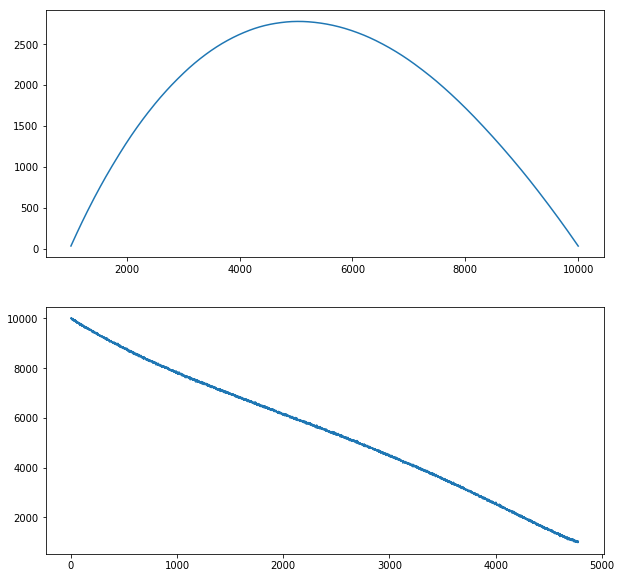

In [23]:
import matplotlib.pyplot as plt

x, y, r = [], [], []

for xnew, ynew in projectile():
    x.append(xnew)
    y.append(ynew)
    r.append(radar_signal(xnew, ynew))
    
x = np.array(x)
y = np.array(y)
r = np.array(r)

_, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].plot(x, y)
ax[1].plot(r)

# További olvasnivalók

1. http://www.it.uu.se/research/systems_and_control/education/2019/smc/schedule/lecture4.pdf

2. http://www.dcsc.tudelft.nl/~sc4081/2018/assign/pap/andrea_PFR_paper.pdf

3. https://www.jhuapl.edu/content/techdigest/pdf/V29-N01/29-01-Palumbo_Guidance.pdf

4. https://www.scienceabc.com/eyeopeners/how-low-must-aircraft-fly-to-avoid-radar-detection-low-altitude-flying.html

5. https://en.wikipedia.org/wiki/AK-630

6. https://ru.wikipedia.org/wiki/2%D0%A14

7. https://en.wikipedia.org/wiki/Kalman_filter

8. https://vibit-adm.ru/granatomet/240-mm-minomet-m-2.html

9. https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb

10. https://www.mathworks.com/matlabcentral/fileexchange/35468-particle-filter-tutorial